# Make prediction based on satellite-based estimates of CRH and upward shift, using $\beta=1.2$

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

import helpers as hlp

import sys
sys.path.append("../analysis/")
from cmip6radheating import define_targetlevels

Loads CRH obs data.

In [2]:
clca = hlp.acre_obs_2bflxhrlidar_r05() # 2b-lx-lidar r05
cccm = hlp.acre_obs_cccm()    # cccm

Predicts CRH change from upward shift.

In [3]:
def dcrh_upwardshift(_crh, _beta):
    """ Predicts CRH change based on upward shift of reference crh.
        Returns xarray datarray.
    """
    _lev = _crh.lev
    _lat = _crh.lat
    # do we need to reverse vertical axis so that pressure is increasing?
    lreverse=False
    if _lev[0]>_lev[1]:
        lreverse=True
        _lev = _lev[::-1]
        _crh = _crh[::-1,:]
    _crh_shift = _crh + np.nan
    # interpolate shifted crh from levels lev/beta to input levels lev
    for ilat in range(0, _lat.size):
        _crh_shift[:, ilat] = np.interp(_lev, _lev/_beta, _crh[:, ilat]) 
    # reverse pressure back if reversed previously
    if lreverse: 
        _crh = _crh[::-1,:]
        _crh_shift = _crh_shift[::-1,:]
    return _crh_shift - _crh

In [4]:
dcrh_clca = dcrh_upwardshift(clca, _beta=1.2)
dcrh_cccm = dcrh_upwardshift(cccm, _beta=1.2)

Makes plot.

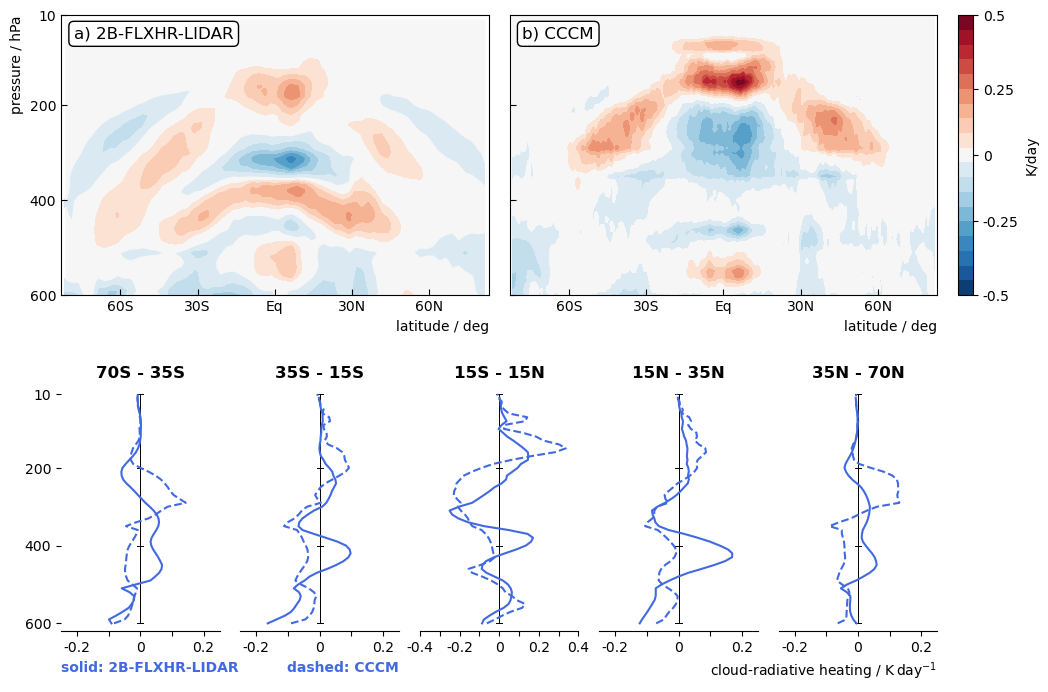

In [5]:
clev=0.5*np.delete(1.0*np.linspace(-1,1,21),10) # contour levels, remove 0

# restrict plot to levels above 600 hPa
dcrh_clca = dcrh_clca.sel(lev=slice(600e2, 0))
dcrh_cccm = dcrh_cccm.sel(lev=slice(600e2, 0))

def _make_niceaxes_contour(ax):
    plt.ylim(600,10)
    plt.yticks([600,400,200],[" ", " ", " "], size=10);
    plt.xlim(-83,83)
    plt.xticks([-60,-30,0,30,60],["60S", "30S", "Eq", "30N", "60N"], size=10, va="top");
    ax.tick_params(direction="in", length=4)
    plt.xlabel("latitude / deg", size=10, loc="right")

def _plot_crh_singledata(_crh, linestyle="-"):
    plt.plot(_crh, _crh.lev/100, color="royalblue", linestyle=linestyle)
    plt.yticks([800,600,400,200],["800", "600","400","200"], size=6);
    return

def _make_niceaxes_profile(ax, xlim=[-0.2,0.2]):
    # adjust spines
    ax.spines["top"].set_color("none")
    ax.spines["right"].set_color("none")
    ax.spines["left"].set_color("none")
    ax.xaxis.set_ticks_position("bottom")
    ax.spines["bottom"].set_position(("data",620))
    ax.spines["top"].set_position(("data",-100))
    ax.spines["right"].set_position(("data",xlim[1]+0.03))
    ax.yaxis.tick_left()
    ax.yaxis.set_label_position("left")
    plt.xticks([-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5], 
               ["",-0.4,"",-0.2,"",0,"",0.2,"",0.4,""], fontsize=10)
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(620,-100)
    plt.yticks([ ], fontsize=10) 
    plt.plot([0,0], [600,10], linewidth=0.7, color="k", zorder=-10)
    ticklength=0.04*np.abs(xlim[1]-xlim[0])
    for ypos in [600,400,200,10]:
        plt.plot([-0.5*ticklength,0.5*ticklength], [ypos,ypos], linewidth=0.7, color="k", zorder=-10)    

        
fig = plt.figure(figsize=(12,8))
gs = GridSpec(2, 52, figure=fig)

ax1 = fig.add_subplot(gs[0, 1:25])
cnt=plt.contourf(dcrh_clca.lat, dcrh_clca.lev/100, dcrh_clca,  levels=clev, cmap="RdBu_r")
for c in cnt.collections: c.set_edgecolor("face")
_make_niceaxes_contour(ax1)
plt.ylabel("pressure / hPa", loc="top", fontsize=10)
plt.yticks([600,400,200,10], ["600", "400", "200", "10"], fontsize=10)
ax1.text(0.03,0.96, "a) 2B-FLXHR-LIDAR", ha="left", va="top", transform=ax1.transAxes, backgroundcolor="white", 
        size=12, bbox=dict(facecolor="white", edgecolor="k", boxstyle="round,pad=0.3"))

ax2 = fig.add_subplot(gs[0, 26:50])
cnt=plt.contourf(dcrh_cccm.lat, dcrh_cccm.lev/100, dcrh_cccm,  levels=clev, cmap="RdBu_r")
for c in cnt.collections: c.set_edgecolor("face")
_make_niceaxes_contour(ax2)
ax2.text(0.03,0.96, "b) CCCM", ha="left", va="top", transform=ax2.transAxes, backgroundcolor="white", 
        size=12, bbox=dict(facecolor="white", edgecolor="k", boxstyle="round,pad=0.3"))

ax3 = fig.add_subplot(gs[1, 1:10])
_plot_crh_singledata(hlp.compute_domainmean(dcrh_clca, lats=-70, latn=-35))
_plot_crh_singledata(hlp.compute_domainmean(dcrh_cccm, lats=-70, latn=-35), linestyle="--")
_make_niceaxes_profile(ax3, xlim=[-0.25,0.25])
plt.yticks([600,400,200,10], [600,400,200,10], fontsize=10)
plt.text(0.5, 0.92, "70S - 35S", fontsize=12, fontweight="bold", 
         ha="center" , va="center", transform=ax3.transAxes)
plt.xlabel("solid: 2B-FLXHR-LIDAR", fontsize=10, fontweight="bold", color="royalblue", loc="left")

ax4 = fig.add_subplot(gs[1, 11:20])
_plot_crh_singledata(hlp.compute_domainmean(dcrh_clca, lats=-35, latn=-15))
_plot_crh_singledata(hlp.compute_domainmean(dcrh_cccm, lats=-35, latn=-15), linestyle="--")
_make_niceaxes_profile(ax4, xlim=[-0.25,0.25])
plt.text(0.5, 0.92, "35S - 15S", fontsize=12, fontweight="bold", 
         ha="center" , va="center", transform=ax4.transAxes)
plt.xlabel("dashed: CCCM", fontsize=10, fontweight="bold", color="royalblue", loc="right")

ax5 = fig.add_subplot(gs[1, 21:30])
_plot_crh_singledata(hlp.compute_domainmean(dcrh_clca, lats=-15, latn=+15))
_plot_crh_singledata(hlp.compute_domainmean(dcrh_cccm, lats=-15, latn=+15), linestyle="--")
_make_niceaxes_profile(ax5, xlim=[-0.4,0.4])
plt.text(0.5, 0.92, "15S - 15N", fontsize=12, fontweight="bold", 
         ha="center" , va="center", transform=ax5.transAxes)

ax6 = fig.add_subplot(gs[1, 31:40])
_plot_crh_singledata(hlp.compute_domainmean(dcrh_clca, lats=+15, latn=+35))
_plot_crh_singledata(hlp.compute_domainmean(dcrh_cccm, lats=+15, latn=+35), linestyle="--")
_make_niceaxes_profile(ax6, xlim=[-0.25,0.25])
plt.text(0.5, 0.92, "15N - 35N", fontsize=12, fontweight="bold", 
         ha="center" , va="center", transform=ax6.transAxes)

ax7 = fig.add_subplot(gs[1, 41:50])
_plot_crh_singledata(hlp.compute_domainmean(dcrh_clca, lats=+35, latn=+70))
_plot_crh_singledata(hlp.compute_domainmean(dcrh_cccm, lats=+35, latn=+70), linestyle="--")
_make_niceaxes_profile(ax7, xlim=[-0.25,0.25])
plt.xlabel(r"cloud-radiative heating / K$\,$day$^{-1}$", size=10, loc="right");
plt.text(0.5, 0.92, "35N - 70N", fontsize=12, fontweight="bold", 
         ha="center" , va="center", transform=ax7.transAxes)

# plot colorbar
# solution taken and adapted from https://stackoverflow.com/a/62436015
ax8 = fig.add_subplot(gs[0, 51])
cb = mpl.colorbar.ColorbarBase(ax8, orientation="vertical", 
                               cmap="RdBu_r", ticks=[-0.5, -0.25, 0.0, 0.25, 0.5],
                               label="K/day",
                               boundaries=clev, norm=mpl.colors.Normalize(clev[0], clev[-1]))     
cb.ax.set_yticklabels(["-0.5", "-0.25", "0", "0.25", "0.5"])
cb.ax.tick_params(labelsize=10)
cb.set_label(label="K/day", size=10)

plt.savefig("./figures/obs_prediction.pdf")